• **DOMAIN:** Entertainment<BR>
• **CONTEXT:** Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company wants to automate the process of cast and crew information in each scene from a movie such that when a user pauses on the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.<BR>
• **DATA DESCRIPTION**: The dataset comprises of images and its mask where there is a human face.<BR>
• **PROJECT OBJECTIVE**: Face detection from training images.<BR>
Steps and tasks: [ Total Score: points]
1. Import the dataset.
2. Create features (images) and labels (mask) using that data.
3. Mask detection model:
    - Design a face mask detection model.<BR>
       **Hint**: Use U-net along with pre-trained transfer learning models
    - Design your own Dice Coe"icient and Loss function.
    - Train, tune and test the model.
    - Evaluate the model using testing data.
4. Use the “Prediction image” as an input to your designed model and display the output of the image.

## 1. Import the dataset

In [1]:
# import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# load the dataset
data = np.load('Part 1- Train data - images.npy', allow_pickle=True)

In [3]:
# to check the shape of the data
data.shape

# the data has 409 images and 2 labels

(409, 2)

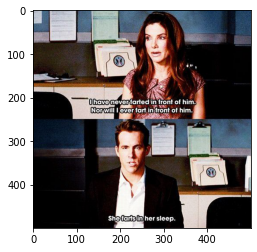

In [4]:
# Let's check the random images
data[5][1]
plt.imshow(data[5][0])

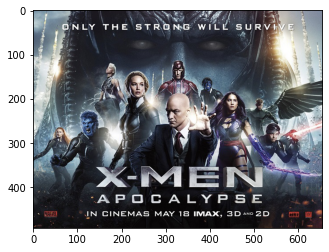

In [5]:
data[408][0]
plt.imshow(data[408][0])

In [6]:
data[408][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.3201219512195122, 'y': 0.2839756592292089},
   {'x': 0.4009146341463415, 'y': 0.4198782961460446}],
  'imageWidth': 656,
  'imageHeight': 493},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.4557926829268293, 'y': 0.38742393509127787},
   {'x': 0.5442073170731707, 'y': 0.5618661257606491}],
  'imageWidth': 656,
  'imageHeight': 493},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.6707317073170732, 'y': 0.38336713995943206},
   {'x': 0.7134146341463414, 'y': 0.4746450304259635}],
  'imageWidth': 656,
  'imageHeight': 493},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.16615853658536586, 'y': 0.4665314401622718},
   {'x': 0.22560975609756098, 'y': 0.563894523326572}],
  'imageWidth': 656,
  'imageHeight': 493},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.07164634146341463, 'y': 0.539553752535497},
   {'x': 0.11280487804878049, 'y': 0.5862068965517241}],
  'imageWidth': 656,
  'imageHeight

In [7]:
# Now let's see the random images and their labels
import cv2

cv2.imshow('image',data[23][0])
cv2.waitKey(0)

cv2.destroyAllWindows()

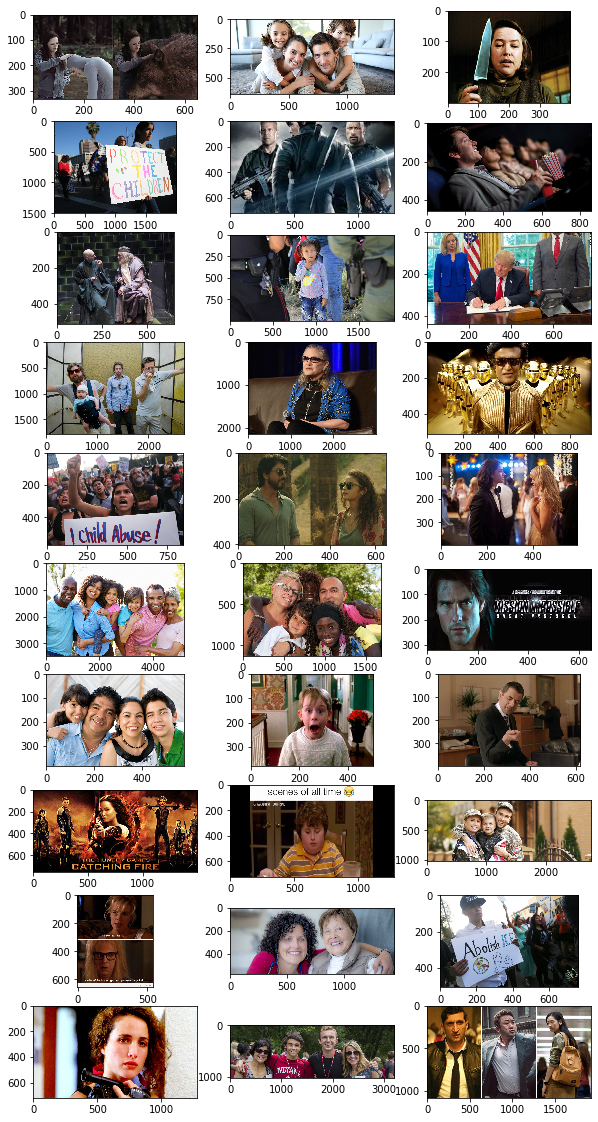

In [8]:
# plotting the images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=10,ncols=3,figsize=(10,20))

rows = 0
cols = 0
index = 0

for i in range(30):
    ax[rows][cols].imshow(data[index][0], interpolation='nearest')
    index += 13
    cols += 1
    if cols > 2:
        rows += 1
        cols = 0
plt.show()

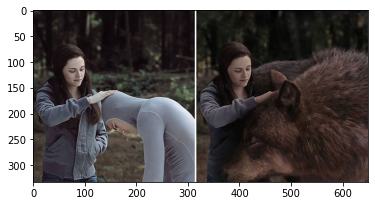

In [9]:
#reviewing the above first image as a single image
plt.imshow(data[0][0])

**creating features (images) and labels (mask)**

In [4]:
import tensorflow
tensorflow.__version__

'2.8.0'

In [11]:
from tensorflow.keras.applications.mobilenet import preprocess_input

image_height = 224
image_width = 224

height_cells = 28
width_cells = 28

image_size = 224

masks = np.zeros((int(data.shape[0]), image_height, image_width))
X = np.zeros((int(data.shape[0]), image_height, image_width, 3))
                 
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(image_height, image_width), interpolation = cv2.INTER_CUBIC)
    # assign all the pixels in the first 3 channels only to the image i.e. discard the alpha channel
    try:
        img = img[:,:,:3]
    except:
        print(f"Exception {index} Grayscale image with shape {img.shape}")
        #convert the grayscale image to color so that the number of channels standardized to 3
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        continue
    X[index] = preprocess_input(np.array(img, dtype = np.float32))
    #Loop through the face co-ordinates and create mask out of it
    for i in data[index][1]:
        x1 = int(i['points'][0]['x'] * image_width)
        x2 = int(i['points'][1]['x'] * image_width)
        y1 = int(i['points'][0]['y'] * image_height)
        y2 = int(i['points'][1]['y'] * image_height)
        # set all pixels within mask co-ordinates to 1.
        masks[index][y1:y2, x1:x2] = 1
print(f"## The shape of X is '{X.shape}' and the shape of mask is '{masks.shape}'")

Exception 272 Grayscale image with shape (224, 224)
## The shape of X is '(409, 224, 224, 3)' and the shape of mask is '(409, 224, 224)'


##### Splitting the data into train and test sets

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size = 0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.2)

print(f"Shape of X_train is '{X_train.shape}' and the shape of y_train is '{y_train.shape}'")
print(f"Shape of X_val is '{X_val.shape}' and the shape of y_val is '{y_val.shape}'")
print(f"Shape of X_test is '{X_test.shape}' and the shape of y_test is '{y_test.shape}'")

Shape of X_train is '(327, 224, 224, 3)' and the shape of y_train is '(327, 224, 224)'
Shape of X_val is '(65, 224, 224, 3)' and the shape of y_val is '(65, 224, 224)'
Shape of X_test is '(17, 224, 224, 3)' and the shape of y_test is '(17, 224, 224)'


##### Visualising X_train and y_train images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


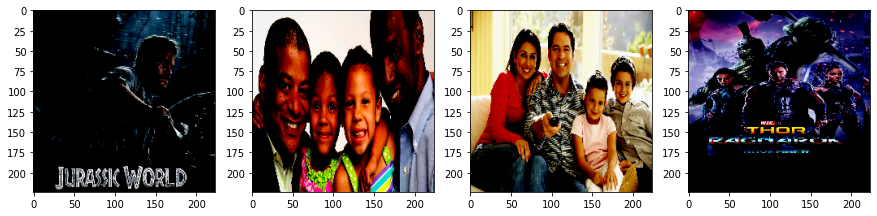

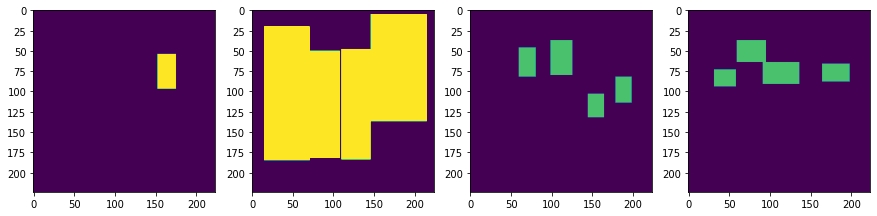

In [13]:
fig = plt.figure(figsize = (15,15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(X_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(X_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(X_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(X_train[30])
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(y_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(y_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(y_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(y_train[30])
imgplot.set_clim(0.0, 1.4)

- **Creating a Mask Detection Model using U-net with MobileNet Transfer Learning Model**

In [14]:
image_size = 224
epochs = 30
batch = 8
lr = 1e-4

In [15]:
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from PIL import Image
from numpy import asarray

def model():
    inputs = Input(shape=(image_size, image_size, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [16]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                                )                                                             

 ization)                                                                                         
                                                                                                  
 block_3_expand_relu (ReLU)     (None, 56, 56, 48)   0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 48)   0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 48)  432         ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 48)  192         ['block_3_depthwise[0][0]']      
 malizatio

                                                                                                  
 block_6_project_BN (BatchNorma  (None, 14, 14, 24)  96          ['block_6_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 144)  3456        ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 144)  576        ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 144)  0           ['block_7_expand_BN[0][0]']      
          

 block_10_depthwise_BN (BatchNo  (None, 14, 14, 144)  576        ['block_10_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 144)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 32)   4608        ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 32)  128         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_

                                                                                                  
 concatenate_1 (Concatenate)    (None, 56, 56, 112)  0           ['up_sampling2d_1[0][0]',        
                                                                  'block_3_expand_relu[0][0]']    
                                                                                                  
 conv2d_2 (Conv2D)              (None, 56, 56, 48)   48432       ['concatenate_1[0][0]']          
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 56, 56, 48)  192         ['conv2d_2[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_2 (Activation)      (None, 56, 56, 48)   0           ['batch_normalization_2[0][0]']  
          

**Designing Dice Coefficient and Loss function**

In [17]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

**Compliling the Model**

In [18]:
import tensorflow as tf

opt = tf.keras.optimizers.Nadam(lr)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [19]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

**Training the Model**

In [20]:
train_steps = len(X_train)//batch
valid_steps = len(X_val)//batch

if len(X_train) % batch != 0:
    train_steps += 1
if len(X_val) % batch != 0:
    valid_steps += 1

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/30
41/41 [==============================] - 67s 1s/step - loss: 0.7263 - dice_coef: 0.2744 - recall: 0.7306 - precision: 0.2223 - val_loss: 0.7085 - val_dice_coef: 0.2860 - val_recall: 0.9941 - val_precision: 0.1666 - lr: 1.0000e-04
Epoch 2/30
41/41 [==============================] - 54s 1s/step - loss: 0.5942 - dice_coef: 0.4057 - recall: 0.8696 - precision: 0.4170 - val_loss: 0.7108 - val_dice_coef: 0.2833 - val_recall: 0.9956 - val_precision: 0.1731 - lr: 1.0000e-04
Epoch 3/30
41/41 [==============================] - 55s 1s/step - loss: 0.5455 - dice_coef: 0.4546 - recall: 0.8788 - precision: 0.4868 - val_loss: 0.6859 - val_dice_coef: 0.3065 - val_recall: 0.9903 - val_precision: 0.2185 - lr: 1.0000e-04
Epoch 4/30
41/41 [==============================] - 55s 1s/step - loss: 0.5217 - dice_coef: 0.4783 - recall: 0.8887 - precision: 0.5229 - val_loss: 0.6536 - val_dice_coef: 0.3377 - val_recall: 0.9802 - val_precision: 0.2734 - lr: 1.0000e-04
Epoch 5/30
41/41 [==================

**Evaluating the Model**

In [22]:
test_steps = (len(X_test)//batch)
if len(X_test) % batch != 0:
    test_steps += 1

model.evaluate(X_test, y_test, steps=test_steps)

3/3 [==============================] - 1s 160ms/step - loss: 0.4343 - dice_coef: 0.5620 - recall: 0.5477 - precision: 0.8073


[0.4342588186264038,
 0.5620060563087463,
 0.5477445125579834,
 0.8073149919509888]

The model has precision and recall of 80.73% and 54.77% respectively. The loss is 43% and dice coefficient is 56.2%. 

**Predicting an image that was not used for training and testing the model**

In [24]:
filename = './Part 1Test Data - Prediction Image.jpeg'
unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (image_width, image_height))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

In [25]:
feat_scaled

array([[[ 0.5686275 ,  0.4666667 ,  0.45098042],
        [ 0.56078434,  0.45882356,  0.4431373 ],
        [ 0.5764706 ,  0.47450984,  0.45882356],
        ...,
        [-0.17647058, -0.5058824 , -0.73333335],
        [-0.27058822, -0.49019605, -0.75686276],
        [-0.27843136, -0.47450978, -0.7411765 ]],

       [[ 0.6       ,  0.49803925,  0.48235297],
        [ 0.6       ,  0.4901961 ,  0.48235297],
        [ 0.6313726 ,  0.5294118 ,  0.5137255 ],
        ...,
        [-0.20784312, -0.52156866, -0.7490196 ],
        [-0.16862744, -0.40392154, -0.6627451 ],
        [-0.19215685, -0.41176468, -0.6784314 ]],

       [[ 0.54509807,  0.45098042,  0.41960788],
        [ 0.47450984,  0.3803922 ,  0.34901965],
        [ 0.5372549 ,  0.4431373 ,  0.4039216 ],
        ...,
        [-0.14509803, -0.42745095, -0.6627451 ],
        [-0.3098039 , -0.5686275 , -0.827451  ],
        [-0.34117645, -0.5921569 , -0.8509804 ]],

       ...,

       [[-1.        , -1.        , -1.        ],
        [-1

In [26]:
y_pred = model.predict(np.array([feat_scaled]))
y_pred

array([[[[0.25042045],
         [0.07073703],
         [0.06870121],
         ...,
         [0.10879239],
         [0.11195287],
         [0.30523878]],

        [[0.10360432],
         [0.03525597],
         [0.04766181],
         ...,
         [0.04914573],
         [0.03040886],
         [0.06351003]],

        [[0.10284171],
         [0.03775942],
         [0.05065897],
         ...,
         [0.05917284],
         [0.05094892],
         [0.05207029]],

        ...,

        [[0.08749899],
         [0.04750547],
         [0.0778656 ],
         ...,
         [0.0579775 ],
         [0.04753673],
         [0.07007158]],

        [[0.06771165],
         [0.03607652],
         [0.08619934],
         ...,
         [0.06820294],
         [0.05444095],
         [0.08237243]],

        [[0.1875341 ],
         [0.05187216],
         [0.09081903],
         ...,
         [0.09221432],
         [0.10677186],
         [0.22189155]]]], dtype=float32)

In [28]:
pred_mask = cv2.resize((1.0*(y_pred[0] > 0.5)), (image_width,image_height))

**Viewing the predicted image and its face-detected output**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


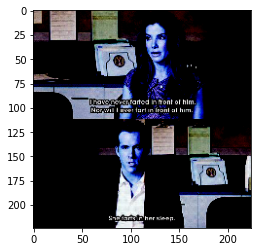

In [29]:
plt.imshow(feat_scaled)

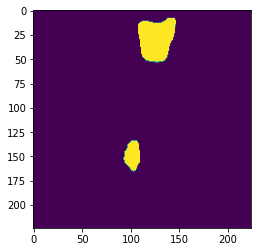

In [30]:
plt.imshow(pred_mask)

The model was able to detect two faces in the image correctly.

# PART-2 

**DOMAIN:** Face recognition<br>
• **CONTEXT:** Company X intends to build a face identi!ication model to recognise human faces.<br>
• **DATA DESCRIPTION:** The dataset comprises of images and its mask where there is a human face.<br>
• **PROJECT OBJECTIVE:** Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken from 'Pinterest' and aligned using dlib library. Some data samples:<br>
• **TASK:** In this problem, we use a pre-trained model trained on Face recognition to recognise similar faces. Here, we are particularly interested in recognising whether two given faces are of the same person or not. Below are the steps involved in the project.<br>
• Load the dataset and create the metadata.<br>
• Check some samples of metadata.<br>
• Load the pre-trained model and weights.<br>
• Generate Embedding vectors for each face in the dataset.<br>
• Build distance metrics for identifying the distance between two given images.
• Use PCA for dimensionality reduction.<br>
• Build an SVM classi!ier in order to map each image to its right person.<br>
• Import the the test image. Display the image. Use the SVM trained model to predict the face.

### loading the data and unzipping it

In [ ]:
from zipfile import ZipFile

# creating a variable for zip file name
file_name = 'Aligned+Face+Dataset+from+Pinterest+-+CV+project+1.zip'

#opening the zip file in READ mode
with ZipFile(file_name, 'r') as z:
    #printing all the contents of the zip file
    #z.printdir()
    
    #extracting all the files
    z.extractall()

In [5]:
import os

directory = os.getcwd() + '\PINS'

In [164]:
import os

directory = os.getcwd() + '\PINS'
directory

os.listdir(directory)

['pins_Aaron Paul',
 'pins_alexandra daddario',
 'pins_Alvaro Morte',
 'pins_alycia debnam carey face',
 'pins_Amanda Crew',
 'pins_Amaury Nolasco',
 'pins_amber heard face',
 'pins_Anna Gunn',
 'pins_anne hathaway',
 'pins_barbara palvin face',
 'pins_bellamy blake face',
 'pins_Benedict Cumberbatch',
 'pins_Betsy Brandt',
 'pins_bill gates',
 'pins_Brenton Thwaites',
 'pins_brie larson',
 'pins_Brit Marling',
 'pins_Bryan Cranston',
 'pins_Caity Lotz',
 'pins_Cameron Monaghan',
 'pins_chadwick boseman face',
 'pins_Chance Perdomo',
 'pins_Chris Evans',
 'pins_Chris Pratt',
 'pins_Cobie Smulders',
 'pins_Danielle Panabaker',
 'pins_Dave Franco',
 'pins_david mazouz',
 'pins_Dominic Purcell',
 'pins_drake',
 'pins_dua lipa face',
 'pins_Dwayne Johnson',
 'pins_eliza taylor',
 'pins_elizabeth olsen face',
 'pins_elon musk',
 'pins_Emilia Clarke',
 'pins_Emily Bett Rickards',
 'pins_Emma Stone',
 'pins_emma watson face',
 'pins_gal gadot face',
 'pins_grant gustin face',
 'pins_Gwyneth P

The images are place inside PINS folder. The folder names begin with the string 'pins_'. The labels of our dataset are the name of the folders containing the names of the people. So we shall rename the folders by removing 'pins_' and replacing all the empty spaces with "_".

In [272]:
for filename in os.listdir(directory):
    os.rename(os.path.join(directory,filename),os.path.join(directory, filename.replace(' ', '_').upper()))
    str = "pins_"
    if str in filename:    
        filepath = os.path.join(directory, filename)
        newfilepath = os.path.join(directory, filename.replace(str, ""))
        os.rename(filepath, newfilepath)

for subdir, dirs, files in os.walk(directory):
    for file in files:
        os.rename(os.path.join(subdir, file), os.path.join(subdir, file.replace(' ', '_')))

### Exploring the dataset

Now, lets view the label names of 100 people.

In [3]:
import glob
import os

paths = glob.glob("PINS/*")
label_names = [os.path.split(x)[1] for x in paths]

print("Total labels: {}".format(len(label_names)))
print("Labels: {}".format((label_names)))

Total labels: 100
Labels: ['AARON_PAUL', 'ALEXANDRA_DADDARIO', 'ALVARO_MORTE', 'ALYCIA_DEBNAM_CAREY_FACE', 'AMANDA_CREW', 'AMAURY_NOLASCO', 'AMBER_HEARD_FACE', 'ANNA_GUNN', 'ANNE_HATHAWAY', 'BARBARA_PALVIN_FACE', 'BELLAMY_BLAKE_FACE', 'BENEDICT_CUMBERBATCH', 'BETSY_BRANDT', 'BILL_GATES', 'BRENTON_THWAITES', 'BRIE_LARSON', 'BRIT_MARLING', 'BRYAN_CRANSTON', 'CAITY_LOTZ', 'CAMERON_MONAGHAN', 'CHADWICK_BOSEMAN_FACE', 'CHANCE_PERDOMO', 'CHRIS_EVANS', 'CHRIS_PRATT', 'COBIE_SMULDERS', 'DANIELLE_PANABAKER', 'DAVE_FRANCO', 'DAVID_MAZOUZ', 'DOMINIC_PURCELL', 'DRAKE', 'DUA_LIPA_FACE', 'DWAYNE_JOHNSON', 'ELIZABETH_OLSEN_FACE', 'ELIZA_TAYLOR', 'ELON_MUSK', 'EMILIA_CLARKE', 'EMILY_BETT_RICKARDS', 'EMMA_STONE', 'EMMA_WATSON_FACE', 'GAL_GADOT_FACE', 'GRANT_GUSTIN_FACE', 'GWYNETH_PALTROW', 'HENRY_CAVIL', 'JASON_ISAACS', 'JASON_MOMOA', 'JEFF_BEZOS', 'JEREMY_RENNER', 'JESSE_EISENBERG', 'JIM_PARSONS', 'JON_BERNTHAL', 'JOSH_RADNOR', 'KIERNAN_SHIPKA', 'KIT_HARINGTON', 'KRISTEN_STEWART_FACE', 'KRYSTEN_RITTER

Next let's create a pandas.DataFrame that stores tha number of images in each folder, the path of the folders, and their images.

In [6]:
import pandas as pd

df = pd.DataFrame(columns=['Person', 'No. of Images','File Path', 'Files'])

folders = [x[0] for x in os.walk(directory)]

for subfolders in folders:
    fileList = os.listdir(subfolders)
    filePath = os.path.abspath(subfolders)
    person = (subfolders)[len(directory):]
    df = df.append({'Person': person, 'No. of Images': len(fileList), 'File Path': filePath , 'Files': fileList}, ignore_index=True)

df

C:\Users\manvi\AppData\Local\Temp\ipykernel_11044\162620484.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Person': person, 'No. of Images': len(fileList), 'File Path': filePath , 'Files': fileList}, ignore_index=True)
C:\Users\manvi\AppData\Local\Temp\ipykernel_11044\162620484.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Person': person, 'No. of Images': len(fileList), 'File Path': filePath , 'Files': fileList}, ignore_index=True)
C:\Users\manvi\AppData\Local\Temp\ipykernel_11044\162620484.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Person': person, 'No. of Images': len(fileList), 'File Path': filePath , 'Files': fileList}, ignore_index=True)
C:\User

C:\Users\manvi\AppData\Local\Temp\ipykernel_11044\162620484.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Person': person, 'No. of Images': len(fileList), 'File Path': filePath , 'Files': fileList}, ignore_index=True)
C:\Users\manvi\AppData\Local\Temp\ipykernel_11044\162620484.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Person': person, 'No. of Images': len(fileList), 'File Path': filePath , 'Files': fileList}, ignore_index=True)
C:\Users\manvi\AppData\Local\Temp\ipykernel_11044\162620484.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Person': person, 'No. of Images': len(fileList), 'File Path': filePath , 'Files': fileList}, ignore_index=True)
C:\User

C:\Users\manvi\AppData\Local\Temp\ipykernel_11044\162620484.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Person': person, 'No. of Images': len(fileList), 'File Path': filePath , 'Files': fileList}, ignore_index=True)
C:\Users\manvi\AppData\Local\Temp\ipykernel_11044\162620484.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Person': person, 'No. of Images': len(fileList), 'File Path': filePath , 'Files': fileList}, ignore_index=True)
C:\Users\manvi\AppData\Local\Temp\ipykernel_11044\162620484.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Person': person, 'No. of Images': len(fileList), 'File Path': filePath , 'Files': fileList}, ignore_index=True)
C:\User

Person No. of Images  \
0                                        100   
1                  \AARON_PAUL            86   
2          \ALEXANDRA_DADDARIO           165   
3                \ALVARO_MORTE            91   
4    \ALYCIA_DEBNAM_CAREY_FACE           144   
..                         ...           ...   
96             \URSULA_CORBERO            80   
97           \WENTWORTH_MILLER           113   
98              \WILLA_HOLLAND           147   
99           \WILLIAM_FICHTNER           139   
100                   \ZENDAYA           109   

                                             File Path  \
0                        C:\Users\manvi\Downloads\PINS   
1             C:\Users\manvi\Downloads\PINS\AARON_PAUL   
2     C:\Users\manvi\Downloads\PINS\ALEXANDRA_DADDARIO   
3           C:\Users\manvi\Downloads\PINS\ALVARO_MORTE   
4    C:\Users\manvi\Downloads\PINS\ALYCIA_DEBNAM_CA...   
..                                                 ...   
96        C:\Users\manvi\Downloads\PINS\URSULA_CORBERO   
97      C:\Users\manvi\Downloads\PINS\WENTWORTH_MILLER   
98         C:\Users\manvi\Downloads\PINS\WILLA_HOLLAND   
99      C:\Users\manvi\Downloads\PINS\WILLIAM_FICHTNER   
100              C:\Users\manvi\Downloads\PINS\ZENDAYA   

                                                 Files  
0    [AARON_PAUL, ALEXANDRA_DADDARIO, ALVARO_MORTE,...  
1    [Aaron_Paul0_262.jpg, Aaron_Paul101_247.jpg, A...  
2    [alexandra_daddario0.jpg, alexandra_daddario1....  
3    [Alvaro_Morte100_825.jpg, Alvaro_Morte101_873....  
4    [alycia_debnam_carey_face1.jpg, alycia_debnam_...  
..                                                 ...  
96   [Ursula_Corbero101_2348.jpg, Ursula_Corbero104...  
97   [Wentworth_Miller0.jpg, Wentworth_Miller10.jpg...  
98   [Willa_Holland0.jpg, Willa_Holland1.jpg, Willa...  
99   [William_Fichtner0.jpg, William_Fichtner1.jpg,...  
100  [zendaya0.jpg, zendaya1.jpg, zendaya10.jpg, ze...  

[101 rows x 4 columns]

now, let's look at random 10 images of each person in the dataset

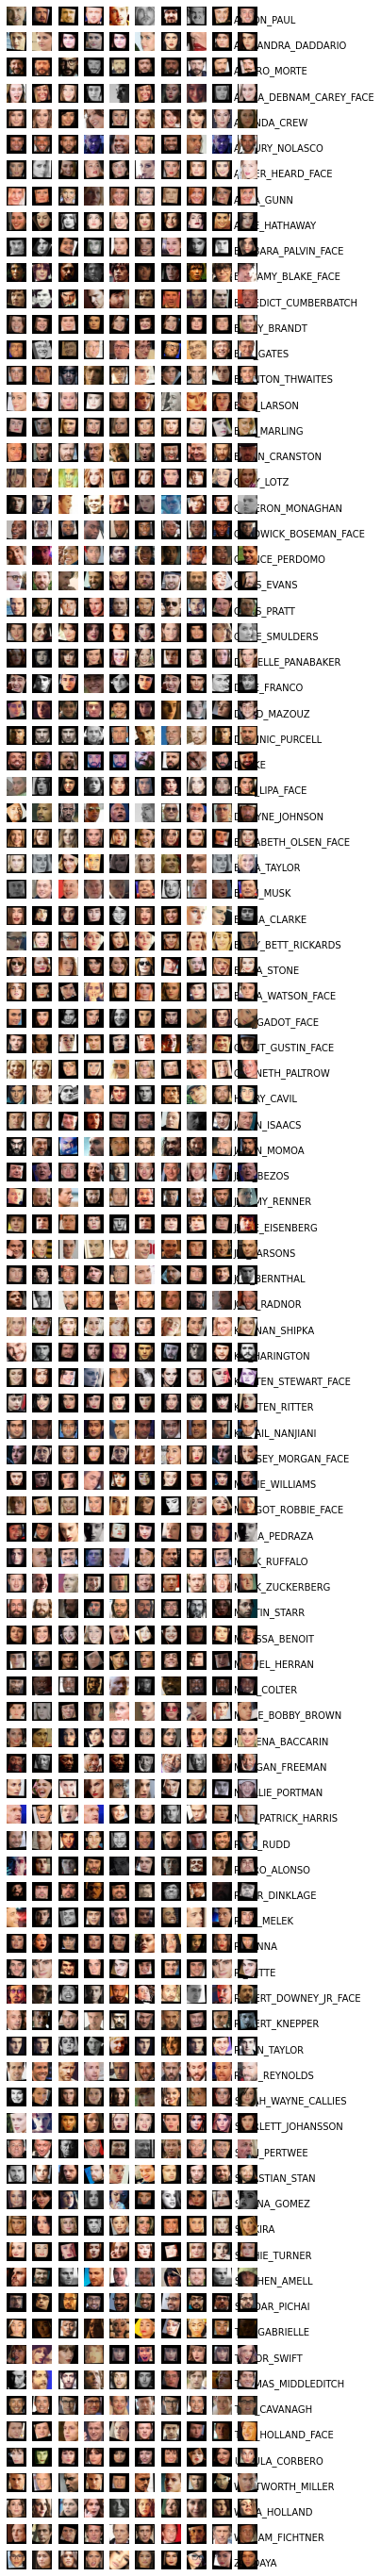

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import cv2

fig = plt.figure(1, (150, 50))
grid = ImageGrid(fig, 111, nrows_ncols=(100, 10), axes_pad=0.1)

n_img_class = []
counter = 0
for idx, label in enumerate(label_names):
    paths = glob.glob(os.path.join("PINS", label, "*.jpg"))
    n_img_class.append([label, len(paths)])
    perm = np.random.choice(len(paths), size=10)

    title = True
    for ii in perm:
        ax = grid[counter]
        if title:
            ax.text(1800, 105, label, verticalalignment="center")
            title = False
        img = cv2.imread(paths[ii])
        img = cv2.resize(img, (150, 150))
        ax.axis("off")
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        counter += 1
        
plt.show()

We will not include all the images in the images array and label names in the classes array, to analyze the distribution of images.

In [7]:
#save the path into variable to use it easily next times.
TRAIN_FOLDER= "PINS"

In [9]:
import cv2
from glob import glob
images = []
classes=[]
missing=0
for class_folder_name in os.listdir(TRAIN_FOLDER):
    class_folder_path = os.path.join(TRAIN_FOLDER, class_folder_name)
    class_label = class_folder_name
    
    for image_path in glob(os.path.join(class_folder_path, "*.jpg")):
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image_bgr is None: # if the file contain any missing value ignore it
            missing += 1
            continue
        images.append(image_bgr)
        
        classes.append(class_label)

In [10]:
len(images)

10770

There are 10770 images in total. All the images are of varied sizes. Let's resize all the images to 224 * 224 pixels.

In [12]:
import numpy as np

In [13]:
# resize image
def resize_images(img):

    img = np.array(img).astype(np.uint8)
    #print(img.dtype)
    res = cv2.resize(img,(224,224), interpolation = cv2.INTER_CUBIC)
    return res

#save resized images into images.
images = [resize_images(img) for img in images]

In [14]:
images[0].shape

(224, 224, 3)

In [15]:
#see number of images in each label
images = np.array(images)
classes = np.array(classes)
print("images shape: ", images.shape)
print("classes shape: ", classes.shape)

images shape:  (10770, 224, 224, 3)
classes shape:  (10770,)


The images are colored. Thus they are 3 dimentinal i.e. RGB channels (Red, Green, Blue)

### Viewing the distribution of number of images in each class

In [17]:
import matplotlib.pyplot as plt

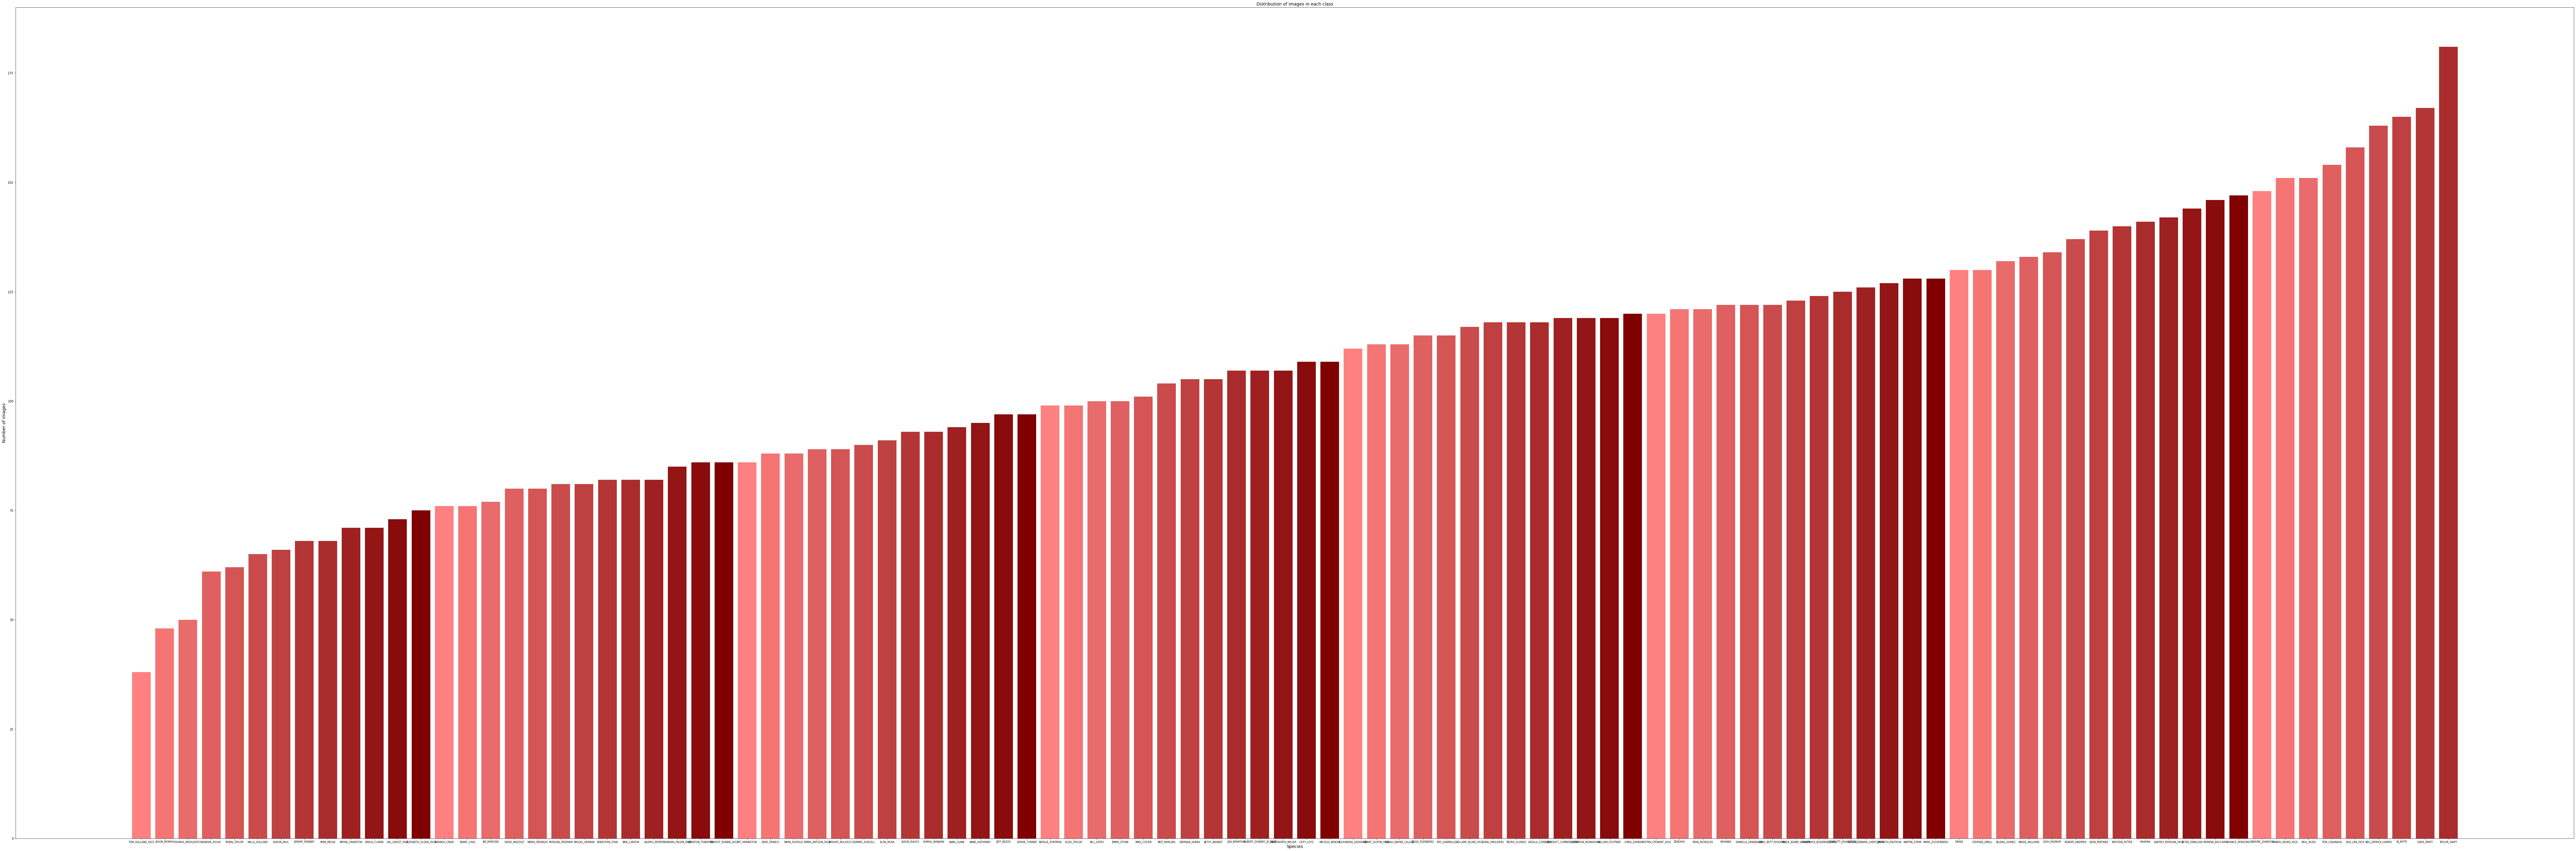

In [18]:
import matplotlib as mp

values =[]
labels=[]
for label in set(classes):
    values.append(len(images[classes == label]))
    labels.append(label)

values.sort()

code=np.arange(0,13,1)
data_normalizer = mp.colors.Normalize()
color_map = mp.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 1.0, 1.0),
                (1.0, .5, .5)],
        "green": [(0, 0.5, 0.5),
                  (1.0, 0, 0)],
        "blue": [(0, 0.50, 0.5),
                 (1.0, 0, 0)]
    }
)

fig, ax = plt.subplots(figsize=(150,50))
ax.bar(labels, values, color=color_map(data_normalizer(code)))
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 10)
plt.xlabel("Species", fontsize = 14)
plt.ylabel("Number of images", fontsize = 14)
plt.title("Distribution of images in each class", fontsize=14)
plt.show()

from the above, we can infer that all the folders does not have equal number of images. The dagtaset is imbalanced.

Lets view a sample image based on index

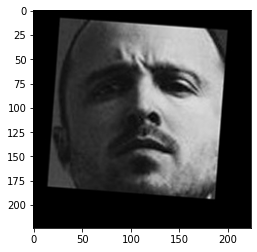

In [88]:
plt.imshow(images[50])

Let's view images based on class

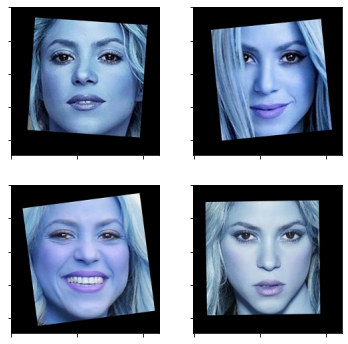

In [89]:
def plot_for_class(label):
    nb_rows = 2
    nb_cols = 2
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))
    class_images =images[classes== label]
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(class_images[n])
            n += 1 
plot_for_class("SHAKIRA")

The metadata for each image (file and identity name) are loaded into memory for later processing.

In [19]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('PINS')

In [20]:
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from PIL import Image
from numpy import asarray

In [21]:
pip show keras-vggface

Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: c:\users\manvi\appdata\local\programs\python\python310\lib\site-packages
Requires: h5py, keras, numpy, pillow, pyyaml, scipy, six
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [22]:
# check version of keras_vggface
import keras_vggface
# print version
print(keras_vggface.__version__)

0.6


In [23]:
weights_file = 'Part 2 - vgg_face_weights.h5'

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K

# Define VGG_FACE_MODEL architecture
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))	
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

# Load VGG Face model weights
model.load_weights(weights_file)

In [31]:
# Remove last Softmax layer and get model upto last flatten layer #with outputs 2622 units 
vgg_face_descriptor=Model(inputs=model.layers[0].input,outputs=model.layers[-2].output) 

# **Detecting Faces for Face Recognition**

In [32]:
# confirm mtcnn was installed correctly
import mtcnn
# print version
print(mtcnn.__version__)

0.1.0


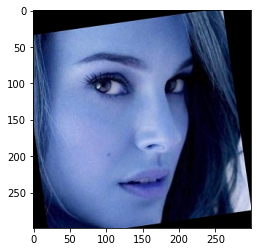

In [64]:
sample_pic = r"C:\Users\manvi\Downloads\PINS\NATALIE_PORTMAN\Natalie_Portman_22.jpg"

# load image from file
image = cv2.imread(sample_pic)
plt.imshow(image)

Next, initialize an MTCNN() object into the detector variable and use the .detect_faces() method to detect the faces in an image. Let’s see what it returns:

In [65]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
from mtcnn.mtcnn import MTCNN

# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
faces = detector.detect_faces(sample_pic)
faces

For every face, a Python dictionary is returned, which contains three keys. The box key contains the boundary of the face within the image. It has four values: x- and y- coordinates of the top left vertex, width, and height of the rectangle containing the face. The other keys are confidence and keypoints. The keypoints key contains a dictionary containing the features of a face that were detected, along with their coordinates:

# **Highlighting Faces in an Image**

Now that we’ve successfully detected a face, let’s draw a rectangle over it to highlight the face within the image to verify if the detection was correct.

To draw a rectangle, import the Rectangle object from matplotlib.patches:

In [67]:
from matplotlib.patches import Rectangle

Let’s define a function highlight_faces to first display the image and then draw rectangles over faces that were detected. First, read the image through imread() and plot it through imshow(). For each face that was detected, draw a rectangle using the Rectangle() class.

Finally, display the image and the rectangles using the .show() method. If you’re using Jupyter notebooks, you may use the %matplotlib inline magic command to show plots inline:

In [68]:
def highlight_faces(image_path, faces):
  # display image
    image = plt.imread(image_path)
    plt.imshow(image)

    ax = plt.gca()

    # for each face, draw a rectangle based on coordinates
    for face in faces:
        x, y, width, height = face['box']
        face_border = Rectangle((x, y), width, height,
                          fill=False, color='red')
        ax.add_patch(face_border)
    plt.show()

In [ ]:
highlight_faces(sample_pic, faces)

Let’s display the second image and the face(s) detected in it:

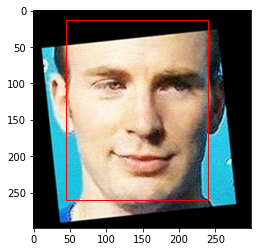

In [76]:
image = plt.imread(r"C:\Users\manvi\Downloads\PINS\CHRIS_EVANS\Chris_Evans34.jpg")
faces = detector.detect_faces(image)

highlight_faces(r"C:\Users\manvi\Downloads\PINS\CHRIS_EVANS\Chris_Evans34.jpg", faces)

In these two images, you can see that the MTCNN algorithm correctly detects faces. Let’s now extract this face from the image to perform further analysis on it.

# **Extracting Face for Further Analysis**

At this point, you know the coordinates of the faces from the detector. Extracting the faces is a fairly easy task using list indices. However, the VGGFace2 algorithm that we use needs the faces to be resized to 224 x 224 pixels. We’ll use the PIL library to resize the images.

The function extract_face_from_image() extracts all faces from an image:

In [77]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	pixels = cv2.imread(filename)
 
	# create the detector, using default weights
	detector = MTCNN()
 
	# detect faces in the image
	results = detector.detect_faces(pixels)
 
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height

	# extract the face
	face = pixels[y1:y2, x1:x2]

	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

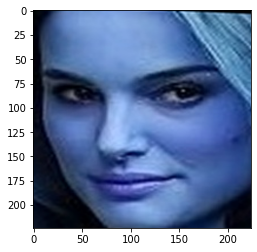

In [79]:
# load the photo and extract the face
pixels = extract_face(r"C:\Users\manvi\Downloads\PINS\NATALIE_PORTMAN\Natalie_Portman_46.jpg")

# plot the extracted face
plt.imshow(pixels)

# show the plot
plt.show()

In [81]:
from numpy import expand_dims
from keras_vggface.utils import preprocess_input

# load the photo and extract the face
pixels = extract_face(r"C:\Users\manvi\Downloads\PINS\NATALIE_PORTMAN\Natalie_Portman_46.jpg")

# convert one face into samples
pixels = pixels.astype('float32')
samples = expand_dims(pixels, axis=0)

# prepare the face for the model, e.g. center pixels
samples = preprocess_input(samples, version=2)

In [82]:
from keras_vggface.utils import decode_predictions

# perform prediction
yhat = vgg_face_descriptor.predict(samples)

# convert prediction into names
results = decode_predictions(yhat)

# display most likely results
for result in results[0]:
	print('%s: %.2f%%' % (result[0], result[1]))

360448/346184 [===============================] - 0s 0us/step
b'Natalie_Portman': 19.45%
b'Jessica_McNamee': 12.00%
b'Mathilda_May': 11.42%
b'Kristina_Anapau': 11.01%
b'Virginie_Ledoyen': 10.97%


# **Performing Face Verification With VGGFace2**

A VGGFace2 model can be used for face verification.

This involves calculating a face embedding for a new given face and comparing the embedding to the embedding for the single example of the face known to the system.

A face embedding is a vector that represents the features extracted from the face. This can then be compared with the vectors generated for other faces. For example, another vector that is close (by some measure) may be the same person, whereas another vector that is far (by some measure) may be a different person.

Typical measures such as Euclidean distance and Cosine distance are calculated between two embeddings and faces are said to match or verify if the distance is below a predefined threshold, often tuned for a specific dataset or application.

First, we can load the VGGFace model without the classifier by setting the ‘include_top‘ argument to ‘False‘, specifying the shape of the output via the ‘input_shape‘ and setting ‘pooling‘ to ‘avg‘ so that the filter maps at the output end of the model are reduced to a vector using global average pooling.

https://machinelearningmastery.com/how-to-perform-face-recognition-with-vggface2-convolutional-neural-network-in-keras/

In [83]:
def get_embeddings(filenames):
	# extract faces
	faces = [extract_face(f) for f in filenames]
	# convert into an array of samples
	samples = asarray(faces, 'float32')
	# prepare the face for the model, e.g. center pixels
	samples = preprocess_input(samples, version=2)

	# perform prediction
	yhat = vgg_face_descriptor.predict(samples)
	return yhat

We can take our photograph of Natalie Portman used previously (e.g. Natalie_Portman_46.jpg) as our definition of the identity of Natalie Portman by calculating and storing the face embedding for the face in that photograph.

We can then calculate embeddings for faces in other photographs of Natalie Portman and test whether we can effectively verify her identity. We can also use faces from photographs of other people to confirm that they are not verified as Natalie Portman.

Verification can be performed by calculating the Cosine distance between the embedding for the known identity and the embeddings of candidate faces. This can be achieved using the cosine() SciPy function. The maximum distance between two embeddings is a score of 1.0, whereas the minimum distance is 0.0. A common cut-off value used for face identity is between 0.4 and 0.6, such as 0.5, although this should be tuned for an application.

The is_match() function below implements this, calculating the distance between two embeddings and interpreting the result.

In [84]:
# determine if a candidate face is a match for a known face
def is_match(known_embedding, candidate_embedding, thresh=0.5):
	# calculate distance between embeddings
	score = cosine(known_embedding, candidate_embedding)
	if score <= thresh:
		print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
	else:
		print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))

In [85]:
from scipy.spatial.distance import cosine

# define filenames
filenames = [r"C:\Users\manvi\Downloads\PINS\NATALIE_PORTMAN\Natalie_Portman_20.jpg",r"C:\Users\manvi\Downloads\PINS\NATALIE_PORTMAN\Natalie_Portman_38.jpg",
             r"C:\Users\manvi\Downloads\PINS\NATALIE_PORTMAN\Natalie_Portman_28.jpg",r"C:\Users\manvi\Downloads\PINS\CHRIS_EVANS\Chris_Evans34.jpg"]
# get embeddings file filenames
embeddings = get_embeddings(filenames)
# define natalie
natalie_id = embeddings[0]
# verify known photos of sharon
print('Positive Tests')
is_match(embeddings[0], embeddings[1])
is_match(embeddings[0], embeddings[2])
# verify known photos of other people
print('Negative Tests')
is_match(embeddings[0], embeddings[3])

Positive Tests
>face is a Match (0.461 <= 0.500)
>face is a Match (0.286 <= 0.500)
Negative Tests
>face is NOT a Match (0.673 > 0.500)


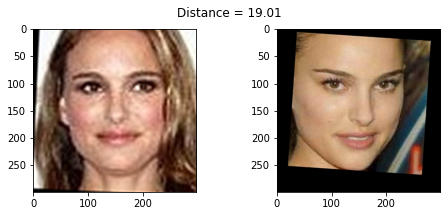

In [86]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[0]/1000, embeddings[2])/1000:.2f}')
    plt.subplot(121)
    img_1 = plt.imread(filenames[idx1])
    plt.imshow(img_1)
    plt.subplot(122)
    img_2 = plt.imread(filenames[idx2])
    plt.imshow(img_2)    

show_pair(0, 2)